In [360]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import os
import pandas as pd
from datetime import datetime
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap

# import neptune.new as neptune
# import neptune.new.integrations.optuna as optuna_utils

%matplotlib inline
from collections import Counter
import math
import seaborn as sns

sns.set_style("ticks")
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestRegressor,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_fscore_support,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
)
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
import functools
import warnings
import gc
import platform

warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

In [291]:
random_state = 57
now = lambda: datetime.now().strftime("%Y-%m-%dT%Hh%Mm%Ss")


def is_databricks():
    return True if "DATABRICKS_RUNTIME_VERSION" in os.environ else False


running_on = platform.system()

if running_on == "Windows":
    path = fr"C:\Users\pmm\ownCloud\jupyter\22-05 HR"
elif running_on == "Darwin":
    path = f"/Users/pmm/ownCloud/jupyter/22-05 HR"
elif "google.colab" in str(get_ipython()):
    path = "/content"
elif is_databricks():
    my_container = "projects"
    my_lake = "tdsdsdatalake"
    mount_point = f"/mnt/{my_container}"
    path = f"{mount_point}"

    configs = {
        "fs.azure.account.auth.type": "CustomAccessToken",
        "fs.azure.account.custom.token.provider.class": spark.conf.get(
            "spark.databricks.passthrough.adls.gen2.tokenProviderClassName"
        ),
    }

    if not any(
        mount.mountPoint == mount_point for mount in dbutils.fs.mounts()
    ):
        dbutils.fs.mount(
            source=f"abfss://{my_container}@{my_lake}.dfs.core.windows.net/",
            mount_point=mount_point,
            extra_configs=configs,
        )

In [292]:
if is_databricks():
    data_file = f"{mount_point}/2022-05 HR/df.parquet"
    df_orig = spark.read.parquet(data_file).select("*").toPandas()
else:
    data_file = f"{path}/df_adj.parquet"
    df_orig = pd.read_parquet(data_file)

In [293]:
df = df_orig.copy()
# df = df[df["start_date"] < "2201-04-01"]

In [294]:
dtypes = {
    "pers_no": "object",
    "job_key": "object",
    "position": "object",
    "job_abbrev": "object",
    "contract": "object",
    "act": "object",
    "reason": "int64",
    "start_date": "datetime64[ns]",
    "most_recent_hire_date_01": "datetime64[ns]",
    "service_anniversary_16": "datetime64[ns]",
    "cocd": "object",
    "org_unit": "object",
    "employee_group": "object",
    "employee_subgroup": "object",
    "commission_type": "object",
    "pay_scale_group_effective_date": "datetime64[ns]",
    "ps_group": "object",
    "prev_ps_group": "object",
    "annl_sal_hrly_wage": "float64",
    "annual_salary": "float64",
    "pay_level_midpoint": "float64",
    "prev_wage": "float64",
    "pts": "int64",
    "supervisor": "object",
    "ps_area": "object",
    "aap": "object",
    "city": "object",
    "state": "object",
    "generation": "object",
    "retiree_medical_eligibility": "object",
    "functional_area": "object",
    "fst": "object",
    "age_at_action": "float64",
    "percent_of_market_after_action": "float64",
    "percent_of_market_before_action": "float64",
    "hired": "object",
    "term": "object",
    "retirement": "object",
    "promotion": "object",
    "progression": "object",
    "previous_job_code": "object",
    "current_bu": "object",
    "previous_bu": "object",
    "gender_most_current": "object",
    "race_ethinicity_most_current": "object",
    "poc_non_poc_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
    "disabled_most_current": "object",
    "tds_vet_excludes_v1_v9_most_current": "object",
}

dt = {col: dtypes[col] for col in df.columns if col in dtypes}
df = df.astype(dt)

In [295]:
# df.head(10)

In [296]:
# df.info()

In [297]:
target = "churned"

In [298]:
X = df.drop(columns=target)
y = df[target]

# train_data, test_data, train_target, test_target = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=random_state
# )

train_data = pd.read_parquet("train_data.parquet")
test_data = pd.read_parquet("test_data.parquet")
train_target = pd.read_csv("train_target.csv", index_col=0)
test_target = pd.read_csv("test_target.csv", index_col=0)

In [299]:
test_data_105 = pd.read_parquet("test_data_105.parquet")
test_data_95 = pd.read_parquet("test_data_95.parquet")

In [300]:
train_data = train_data.drop(
    columns=["reason", "percent_of_market_before_action"]
)
test_data = test_data.drop(
    columns=["reason", "percent_of_market_before_action"]
)
test_data_105 = test_data_105.drop(
    columns=["reason", "percent_of_market_before_action", "churned"]
)
test_data_95 = test_data_95.drop(
    columns=["reason", "percent_of_market_before_action", "churned"]
)

In [301]:
num_cols = [
    "annual_salary",
    "prev_wage",
    "age_at_action",
    "percent_of_market_after_action",
    "gender",
    "emp_subgroup",
    "commission",
    "fst_bool",
    "urg_current",
    "retiree_med",
    "progression_bool",
    "promotion_bool",
    "hired_bool",
    "Time_In_TDS",
    "Time_In_Payscale",
]
cat_cols = [
    "pers_no",
    "job_key",
    "position",
    "job_abbrev",
    "contract",
    "act",
    "start_date",
    "most_recent_hire_date_01",
    "service_anniversary_16",
    "cocd",
    "org_unit",
    "pay_scale_group_effective_date",
    "ps_group",
    "prev_ps_group",
    "supervisor",
    "ps_area",
    "aap",
    "city",
    "state",
    "functional_area",
    "previous_job_code",
    "current_bu",
    "previous_bu",
    "race_ethinicity_most_current",
    "poc_non_poc_most_current",
    "disabled_most_current",
    "tds_vet_excludes_v1_v9_most_current",
]
low_card_cols = [
    "contract",
    "ps_area",
    "functional_area",
    "race_ethinicity_most_current",
    "poc_non_poc_most_current",
    "disabled_most_current",
    "tds_vet_excludes_v1_v9_most_current",
]
ord_cols = "pts"
# high_card_cols = df[cat_cols].drop(columns=low_card_cols).columns

In [302]:
train_data

,pers_no,job_key,position,job_abbrev,contract,act,start_date,most_recent_hire_date_01,service_anniversary_16,cocd,org_unit,pay_scale_group_effective_date,ps_group,prev_ps_group,annual_salary,prev_wage,pts,supervisor,ps_area,aap,city,state,functional_area,age_at_action,percent_of_market_after_action,previous_job_code,current_bu,previous_bu,race_ethinicity_most_current,poc_non_poc_most_current,disabled_most_current,tds_vet_excludes_v1_v9_most_current,gender,emp_subgroup,commission,fst_bool,urg_current,retiree_med,progression_bool,promotion_bool,hired_bool,Time_In_TDS,Time_In_Payscale
16357,34165EA0151B23BD88C8F2F03EAB7F6BE14AB706,20012913,30126842,UD1810,Non-Union Emp,ZD,2021-04-01,2020-07-27,2020-07-27,61,10010353,2020-07-27,4H,4H,53747.2,25.50,3,B087A449F05B21A63D0076AEA9D9FEF0EE236759,50,60,PARSONS,TN,Wireline,38.272416,0.986636,20012913.0,Field Svcs,Field Svcs,White,Non-POC,Yes,No,0.0,0.0,0.0,1,0,0,0,0,0,1.860757,1.860757
5369,BECF0F8F5ECE4BC3A8E59F698648353DBF19A73A,20014455,30121524,UD2322,Non-Union Emp,ZX,2020-04-13,2018-09-26,2018-09-26,383,10015387,2019-07-07,C5,C5,43097.6,20.07,3,57216EA40F502F4F89CD3D37AB99E43989AB693E,51,53,KNOXVILLE,TN,Wireline,37.900068,0.846060,20014455.0,CCO,CCO,White,Non-POC,No,No,0.0,0.0,0.0,0,0,0,0,0,0,3.695155,2.917589
8460,960BA0EF10F51E79B0D06A79BE1C11E9E8D26258,20013784,99999999,UD2235,Non-Union Emp,ZJ,2021-05-15,2019-11-18,2019-11-18,861,10011207,2019-11-18,1E,1E,0.0,27220.00,2,BAB93AF5909F30072A164DD3077B012E541B172F,51,40,COEUR D ALENE,ID,OOT,65.174538,0.000000,20013784.0,CCO,CCO,White,Non-POC,Yes,No,0.0,1.0,1.0,0,0,0,0,0,0,2.550710,2.550710
7221,A6A4E99CDE08CE6AC3F239F5231B4AA1FE06C59F,20012999,30013565,UD1886,Non-Union Emp,ZC,2021-11-01,1987-02-23,1987-02-23,383,10010158,2001-08-19,7E,7E,170780.0,169090.00,3,624DEA5C9863202AE5656A9E509EFBF025CEF917,51,11,WINDSOR,WI,Wireline,61.431896,1.172940,20012999.0,IT,IT,White,Non-POC,Unknown,No,0.0,1.0,0.0,0,0,1,0,0,0,35.285126,20.798860
9507,89771E11229616323D8D1584B2F7F662052B4FB4,20027259,30109619,UD3727,Non-Union Emp,ZD,2020-04-01,2018-07-09,2018-07-09,383,10011980,2018-07-09,3E,3E,87850.0,86130.00,3,BB3DBB2C5FFA016851135070296A75E7065ACA15,51,21,MADISON,WI,Wireline,52.887064,1.132088,20027259.0,IT,IT,White,Non-POC,Unknown,No,1.0,1.0,0.0,0,1,0,0,0,0,3.911449,3.911449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,DDC29F7D2CB50A640E5F2D006168C79A266F42B6,20025630,30132110,UD3500,Non-Union Emp,ZR,2021-10-11,2021-06-09,2021-06-09,951,10011174,2021-06-09,C3,2BN,33280.0,0.00,0,887DD16F05D2EFD3B47058E4D31577CB2E851571,50,40,HOBBS,NM,Cable,27.241615,0.832033,20025630.0,CCO,CCO,Hispanic/Latino,POC,Yes,No,1.0,0.0,1.0,0,1,0,0,0,0,0.992841,0.992841
13982,4F3D031CB65CA462200C1D704D9EAAD16CD5189F,20023260,30101348,UD3192,Non-Union Emp,ZD,2020-01-05,2017-03-13,2017-03-13,951,10015606,2019-11-24,C2,C2,33716.8,15.73,3,6BADB7135C53A4A33EF969BB41C72B2BB273EA62,51,51,BEND,OR,Cable,38.631075,0.885309,20023260.0,Zolo,Zolo,Two or More Races,POC,No,No,1.0,0.0,0.0,0,1,0,0,0,0,5.233859,2.534282
4653,C7B06CEDC495DCA3502089F0DF545B4E5F82FAD1,20014455,30125659,UD2322,Non-Union Emp,ZD,2022-04-01,2018-11-19,2018-11-19,383,10015387,2020-04-12,C5,C5,42473.6,19.59,3,E53895BE2CB51AD649FEAB653AC6DC77569F8662,51,31,MONROE,WI,Wireline,32.191650,0.817454,20014455.0,CCO,CCO,Two or More Races,POC,Unknown,No,0.0,0.0,0.0,0,1,0,0,0,0,3.547308,2.150975
877,F4AE8046B13287DA038767C6DC70240BA6E5C861,20029453,30128143,UD4119,Non-Union Emp,ZX,2021-06-06,2018-10-10,2018-10-10,383,10015387,2020-09-27,2E,2E,56920.0,53200.00,4,25BC4D878449FCB949827CFD4A8DE1CDDC3B77CC,51,20,MADISON,WI,Wireline,27.581109,0.874347,20029453.0,CCO,CCO,White,Non-POC,No,No,0.0,1.0,0.0,0,0,0,0,0,0,3.656824,1.691007


In [303]:
# scaler = StandardScaler()
scaler = RobustScaler()
scaled_train_data = pd.DataFrame(
    scaler.fit_transform(train_data[num_cols]),
    columns=num_cols,
    index=train_data.index,
)
scaled_test_data = pd.DataFrame(
    scaler.transform(test_data[num_cols]),
    columns=num_cols,
    index=test_data.index,
)
scaled_test_data_105 = pd.DataFrame(
    scaler.transform(test_data_105[num_cols]),
    columns=num_cols,
    index=test_data_105.index,
)
scaled_test_data_95 = pd.DataFrame(
    scaler.transform(test_data_95[num_cols]),
    columns=num_cols,
    index=test_data_95.index,
)

In [304]:
ohe_enc = OneHotEncoder(sparse=False)
ohe_enc_train_data = pd.DataFrame(
    ohe_enc.fit_transform(train_data[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=train_data.index,
)
ohe_enc_test_data = pd.DataFrame(
    ohe_enc.transform(test_data[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=test_data.index,
)
ohe_enc_test_data_105 = pd.DataFrame(
    ohe_enc.transform(test_data_105[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=test_data.index,
)
ohe_enc_test_data_95 = pd.DataFrame(
    ohe_enc.transform(test_data_95[low_card_cols]),
    columns=ohe_enc.get_feature_names(),
    index=test_data.index,
)

In [305]:
X_train = pd.concat(
    [scaled_train_data, ohe_enc_train_data, train_data[ord_cols]], axis=1
)
X_test = pd.concat(
    [scaled_test_data, ohe_enc_test_data, test_data[ord_cols]], axis=1
)
X_test_105 = pd.concat(
    [scaled_test_data_105, ohe_enc_test_data_105, test_data_105[ord_cols]],
    axis=1,
)
X_test_95 = pd.concat(
    [scaled_test_data_95, ohe_enc_test_data_95, test_data_95[ord_cols]], axis=1
)
y_train = train_target
y_test = test_target

### XGBoost

In [306]:
# def objective(trial, X=X_train, y=y_train):
#     # X_train, X_val, y_train, y_val = train_test_split(
#     #     X,
#     #     y,
#     #     test_size=0.2,
#     #     shuffle=True,
#     #     stratify=y,
#     #     random_state=random_state,
#     # )
#     # sss = StratifiedShuffleSplit(
#     #     n_splits=10, test_size=0.2, random_state=random_state
#     # )
#     # sss.get_n_splits(X, y)
#     skf = StratifiedKFold(n_splits=5)
#     skf.get_n_splits(X, y)

#     params = {
#         # imbalanced classes
#         # "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 100),
#         "n_estimators": trial.suggest_int("n_estimators", 200, 500),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
#         "learning_rate": trial.suggest_discrete_uniform(
#             "learning_rate", 0.01, 0.1, 0.01
#         ),
#         "subsample": trial.suggest_discrete_uniform(
#             "subsample", 0.5, 1.0, 0.1
#         ),
#         "colsample_bytree": trial.suggest_discrete_uniform(
#             "colsample_bytree", 0.5, 1.0, 0.1
#         ),
#         "gamma": trial.suggest_discrete_uniform("gamma", 0, 9, 1),
#         "scale_pos_weight": 30,
#         "random_state": random_state,
#         "tree_method": "gpu_hist",
#         "objective": "binary:logistic",
#         "eval_metric": "auc",
#         "n_jobs": -1,
#         #         "silent": True,
#     }

#     f1_scores = []
#     model = XGBClassifier(**params)
#     for train_index, val_index in skf.split(X, y):
#         threshold = 0.9
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#         model.fit(X_train, y_train)
#         # y_pred = model.predict_proba(X_val)[:, 1]
#         # y_pred = np.where(y_pred > threshold, 1, 0)
#         y_pred = model.predict(X_val)
#         f1_scores.append(f1_score(y_val, y_pred))

#     return round(np.mean(f1_scores), 6)

In [307]:
# study_name = f"xgb{random_state}"
# db_file = os.path.join(path, f"{now()}_{study_name}.db")
# study = optuna.create_study(
#     study_name=study_name,
#     direction="maximize",
#     # storage=f"sqlite:///{db_file}",
# )

# study.optimize(objective, n_trials=100)

In [308]:
# # study.best_params
# best_params = {
#     "n_estimators": 482,
#     "max_depth": 6,
#     "min_child_weight": 2,
#     "learning_rate": 0.09,
#     "subsample": 0.9,
#     "colsample_bytree": 1.0,
#     "gamma": 5.0,
# }

In [309]:
# model = XGBClassifier(
#     **best_params,
#     scale_pos_weight=30,
#     objective="binary:logistic",
#     eval_metric="auc",
#     random_state=random_state
# )
# model.fit(X_train, y_train)

In [310]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.7,
#               enable_categorical=False, eval_metric='auc', gamma=0.0, gpu_id=-1,
#               importance_type=None, interaction_constraints='',
#               learning_rate=0.060000000000000005, max_delta_step=0, max_depth=9,
#               min_child_weight=2, missing=nan, monotone_constraints='()',
#               n_estimators=439, n_jobs=20, num_parallel_tree=1,
#               predictor='auto', random_state=57, reg_alpha=0, reg_lambda=1,
#               scale_pos_weight=30, subsample=1.0, tree_method='exact',
#               validate_parameters=1, verbosity=None)

In [311]:
# model_params = model.get_params()

In [312]:
# model_params = model.get_xgb_params()

In [313]:
model = joblib.load("salary_2205_hr_xgb_model.pkl")

In [314]:
#  100% salary
# Confusion matrix:
# [[3931   45]
#  [  59   74]]

# f1 score = 0.59

In [315]:
# 105% salary
# Confusion matrix:
# [[3946   30]
#  [  59   74]]

# f1 score = 0.62

In [316]:
# 95% salary
# Confusion matrix:
# [[3579  397]
#  [  59   74]]

# f1 score = 0.25

In [389]:
# y_proba = model.predict_proba(X_test)[:, 1]

# threshold = 0.9
# y_pred = np.where(y_proba > threshold, 1, 0)

y_pred = model.predict(X_test_95)

cf = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{cf}")

f1 = f1_score(y_test, y_pred)
print(f"\nf1 score = {f1:.2}")

Confusion matrix:
[[3579  397]
 [  59   74]]

f1 score = 0.25


In [390]:
y_95 = y_pred

AttributeError: 'int' object has no attribute 'figure'

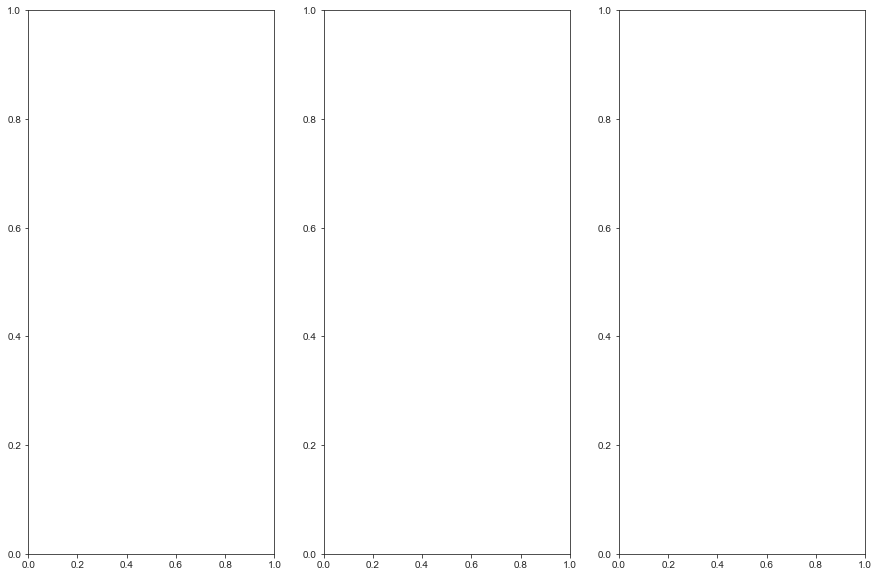

In [479]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
i=1
for title, xtest in [
    ("5% increase*", X_test_105),
    ("Actual increase", X_test),
    ("5% decrease", X_test_95),
]:
    cm = ConfusionMatrixDisplay.from_estimator(
        model,
        xtest,
        y_test,
        ax=i,
        display_labels=["no churn", "churn"],
        cmap=plt.cm.Greens,
        colorbar=False,
    )
    
    # _= cm.plot()
    _= cm.ax_.set_title(title, fontsize=14)
    i += 1

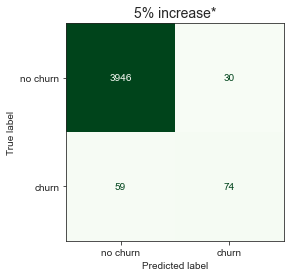

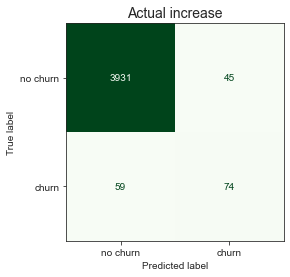

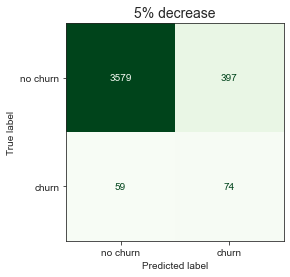

In [358]:
# _ = ConfusionMatrixDisplay(cf).plot()
for title, xtest in [
    ("5% increase*", X_test_105),
    ("Actual increase", X_test),
    ("5% decrease", X_test_95),
]:
    cm = ConfusionMatrixDisplay.from_estimator(
        model,
        xtest,
        y_test,
        display_labels=["no churn", "churn"],
        cmap=plt.cm.Greens,
        colorbar=False,
    )
    
    # _= cm.plot()
    _= cm.ax_.set_title(title, fontsize=14)




In [352]:
# joblib.dump(model, os.path.join(path, "2205_hr_xgb_model.pkl"))

In [320]:
# from BorutaShap import BorutaShap, load_data

# model = XGBClassifier(**model_params)

# Feature_Selector = BorutaShap(
#     model=model, importance_measure="shap", classification=True,
# )

# Feature_Selector.fit(
#     X=X_train,
#     y=y_train,
#     n_trials=100,
#     sample=False,
#     train_or_test="test",
#     normalize=True,
#     verbose=True,
# )

In [321]:
# # Returns Boxplot of features
# Feature_Selector.plot(which_features="all")

In [322]:
# Feature_Selector.Subset().columns

In [323]:
# Feature_Selector.plot(which_features="accepted")

DummyClassifier(random_state=57, strategy='stratified')

0.022388059701492536

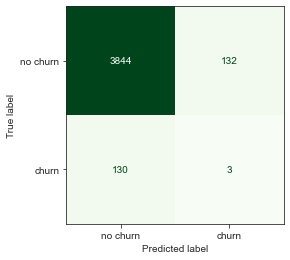

In [384]:
dummy_model = DummyClassifier(strategy="stratified", random_state=random_state)
dummy_model.fit(X_train, y_train)

dy_pred = dummy_model.predict(X_test)

_= ConfusionMatrixDisplay.from_estimator(
        dummy_model,
        X_test,
        y_test,
        display_labels=["no churn", "churn"],
        cmap=plt.cm.Greens,
        colorbar=False,
    )

f1_score(y_test, dy_pred)

In [456]:
tr_105 = (y_105 == True).nonzero()[0]

In [457]:
tr_100 = (y_100 == True).nonzero()[0]

In [458]:
tr_95 = (y_95 == True).nonzero()[0]

In [471]:
print(f"Total true predicted by model: {np.count_nonzero(tr_100)}")
print(f"Predicted true in 5% increase and in 

Total true predicted by model: 119


In [470]:
np.count_nonzero(np.isin(tr_100, tr_105))

104

In [469]:
np.count_nonzero(tr_105)

104

In [441]:
tr_pops = pd.DataFrame({"tr_105": tr_105, "tr_100": tr_100, "tr_95": tr_95})

<Figure size 576x576 with 0 Axes>

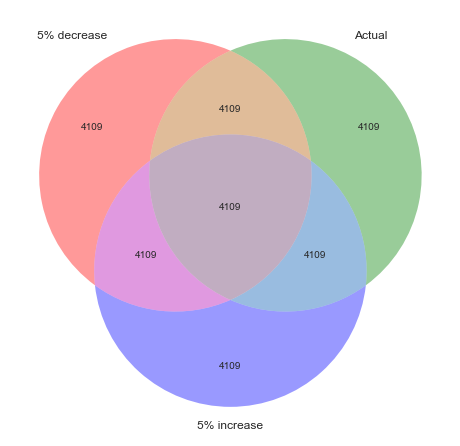

In [477]:
from matplotlib_venn import venn3
plt.figure(figsize=(8,8))
venn3([y_95, y_100, y_105], ("5% decrease", "Actual", "5% increase"))

In [474]:
from matplotlib_venn import venn2

ModuleNotFoundError: No module named 'matplotlib_venn'